In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_49.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_90.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_77.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_54.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_106_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_42.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_81.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_107.wav
/kaggle/input/shl-in

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import librosa
import soundfile as sf
from tqdm import tqdm
from pathlib import Path


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset")
AUDIO_DIR = BASE_DIR / "audios" / "train"

train = pd.read_csv(BASE_DIR / "csvs" / "train.csv")

# Check if filenames include .wav, and fix accordingly
if not train["filename"].iloc[0].endswith(".wav"):
    train["path"] = train["filename"].apply(lambda x: str(AUDIO_DIR / f"{x}.wav"))
else:
    train["path"] = train["filename"].apply(lambda x: str(AUDIO_DIR / x))

# Verify that files actually exist
missing = [p for p in train["path"] if not Path(p).exists()]
print(f"Missing files: {len(missing)}")
if missing:
    print("Example missing paths:", missing[:5])
else:
    print("✅ All files found!")

train.head()


Missing files: 0
✅ All files found!


,filename,label,path
0,audio_173,3.0,/kaggle/input/shl-intern-hiring-assessment-202...
1,audio_138,3.0,/kaggle/input/shl-intern-hiring-assessment-202...
2,audio_127,2.0,/kaggle/input/shl-intern-hiring-assessment-202...
3,audio_95,2.0,/kaggle/input/shl-intern-hiring-assessment-202...
4,audio_73,3.5,/kaggle/input/shl-intern-hiring-assessment-202...


In [5]:
import librosa
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load MFCC features from audio
features = []
for path in tqdm(train['path'], desc="Extracting MFCC features"):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features.append(np.mean(mfcc, axis=1))  # take mean across time

features = np.array(features)

# Create cosine similarity matrix
similarity = cosine_similarity(features)

# Define edges based on top-k similarity
k = 5  # number of neighbors per node
edges = []
for i in range(similarity.shape[0]):
    top_k = np.argsort(similarity[i])[-(k+1):-1]  # exclude self
    for j in top_k:
        edges.append([i, j])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features (optional for Node2Vec — it learns embeddings)
data = Data(edge_index=edge_index)


ModuleNotFoundError: No module named 'torch_geometric'

In [4]:
import librosa
import numpy as np

def load_audio(path, sr=16000, mono=True, max_duration=None):
    try:
        y, _sr = librosa.load(path, sr=sr, mono=mono)
        if max_duration is not None:
            max_len = int(sr * max_duration)
            y = y[:max_len] if len(y) > max_len else librosa.util.fix_length(y, max_len)
        return y
    except Exception as e:
        print(f"⚠️ Error loading {path}: {e}")
        return np.zeros(int(sr * 1.0))  # 1-second silent fallback


In [5]:
import librosa.effects
from tqdm import tqdm

def extract_features(path, sr=16000, n_mfcc=40):
    y = load_audio(path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=20)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats = np.concatenate([
        mfcc.mean(axis=1),
        mfcc.std(axis=1),
        librosa.feature.zero_crossing_rate(y).mean().reshape(-1),
        librosa.feature.spectral_centroid(y=y, sr=sr).mean().reshape(-1),
        librosa.feature.spectral_bandwidth(y=y, sr=sr).mean().reshape(-1)
    ])
    return feats


# Extract features safely
X_feats = []
for p in tqdm(train["path"], desc="Extracting MFCC features"):
    X_feats.append(extract_features(p))

X_feats = np.array(X_feats)
print("✅ Feature matrix shape:", X_feats.shape)


Extracting MFCC features:   0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipykernel_48/481642822.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _sr = librosa.load(path, sr=sr, mono=mono)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC features:   0%|          | 1/409 [00:12<1:26:04, 12.66s/it]/tmp/ipykernel_48/481642822.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _sr = librosa.load(path, sr=sr, mono=mono)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC features:   1%|         

✅ Feature matrix shape: (409, 83)


In [6]:
from sklearn.model_selection import train_test_split

# Ensure label is float (since we are predicting continuous grammar score)
y = train["label"].astype(float)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_feats, y, test_size=0.2, random_state=42
)

print("✅ Train shape:", X_train.shape, "Validation shape:", X_val.shape)


✅ Train shape: (327, 83) Validation shape: (82, 83)


In [9]:
# Random Forest
rf.fit(X_train, y_train)
rf_pred_val = rf.predict(X_val)
rf_pred_train = rf.predict(X_train)

# XGBoost
xgb.fit(X_train, y_train)
xgb_pred_val = xgb.predict(X_val)
xgb_pred_train = xgb.predict(X_train)

# LightGBM
lgb.fit(X_train, y_train)
lgb_pred_val = lgb.predict(X_val)
lgb_pred_train = lgb.predict(X_train)

# Gradient Boosting
gbr.fit(X_train, y_train)
gbr_pred_val = gbr.predict(X_val)
gbr_pred_train = gbr.predict(X_train)

# CatBoost (GPU)
cat.fit(X_train, y_train)
cat_pred_val = cat.predict(X_val)
cat_pred_train = cat.predict(X_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9130
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 83
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [10]:
# Stack base model predictions
X_meta_train = np.column_stack([rf_pred_train, xgb_pred_train, lgb_pred_train, gbr_pred_train, cat_pred_train])
X_meta_val   = np.column_stack([rf_pred_val, xgb_pred_val, lgb_pred_val, gbr_pred_val, cat_pred_val])


In [11]:
meta_model.fit(X_meta_train, y_train)
meta_pred_val = meta_model.predict(X_meta_val)

# Evaluate
rmse = mean_squared_error(y_val, meta_pred_val, squared=False)
accuracy = (1 - rmse / 5) * 100

print(f"\n✅ Validation RMSE: {rmse:.4f}")
print(f"🎯 Estimated Accuracy: {accuracy:.2f}%")



✅ Validation RMSE: 0.7926
🎯 Estimated Accuracy: 84.15%


In [13]:
# ==============================================================
# 📦 Imports
# ==============================================================
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# ==============================================================
# ⚙️ Define Optimized Base Models
# ==============================================================
rf = RandomForestRegressor(n_estimators=1000, max_depth=25, min_samples_split=3, min_samples_leaf=2, random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, reg_lambda=2.0, random_state=42, tree_method='hist', n_jobs=-1)
lgb = LGBMRegressor(n_estimators=1200, learning_rate=0.03, num_leaves=50, subsample=0.85, colsample_bytree=0.85, reg_lambda=1.0, random_state=42, device='cpu', n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=800, learning_rate=0.05, max_depth=5)
cat = CatBoostRegressor(iterations=1500, learning_rate=0.03, depth=7, l2_leaf_reg=5, task_type="GPU", devices='0', random_state=42, verbose=100)

# Meta-model
meta_model = LinearRegression()  # simple linear regression on base predictions

# ==============================================================
# 🔁 Function to train base models and get predictions
# ==============================================================
def train_base_models(X_train, y_train, X_val):
    # Train each model one by one (GPU-safe)
    
    # Random Forest
    print("🚀 Training Random Forest...")
    rf.fit(X_train, y_train)
    rf_train_pred = rf.predict(X_train)
    rf_val_pred = rf.predict(X_val)

    # XGBoost
    print("🚀 Training XGBoost...")
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    xgb_train_pred = xgb.predict(X_train)
    xgb_val_pred = xgb.predict(X_val)

    # LightGBM (fixed: no early stopping)
    print("🚀 Training LightGBM...")
    lgb.fit(X_train, y_train)  # remove eval_set & early_stopping_rounds
    lgb_train_pred = lgb.predict(X_train)
    lgb_val_pred = lgb.predict(X_val)

    # Gradient Boosting
    print("🚀 Training Gradient Boosting...")
    gbr.fit(X_train, y_train)
    gbr_train_pred = gbr.predict(X_train)
    gbr_val_pred = gbr.predict(X_val)

    # CatBoost (GPU)
    print("🚀 Training CatBoost...")
    cat.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    cat_train_pred = cat.predict(X_train)
    cat_val_pred = cat.predict(X_val)

    # Stack predictions
    X_meta_train = np.column_stack([rf_train_pred, xgb_train_pred, lgb_train_pred, gbr_train_pred, cat_train_pred])
    X_meta_val   = np.column_stack([rf_val_pred, xgb_val_pred, lgb_val_pred, gbr_val_pred, cat_val_pred])

    return X_meta_train, X_meta_val

# ==============================================================
# 🔁 Train base models and prepare meta-model features
# ==============================================================
X_meta_train, X_meta_val = train_base_models(X_train, y_train, X_val)

# ==============================================================
# 🔝 Train Meta-Model
# ==============================================================
meta_model.fit(X_meta_train, y_train)
meta_pred_val = meta_model.predict(X_meta_val)

# ==============================================================
# 🎯 Evaluate
# ==============================================================
rmse = mean_squared_error(y_val, meta_pred_val, squared=False)
accuracy = (1 - rmse / 5) * 100

print(f"\n✅ Validation RMSE (Stacked): {rmse:.4f}")
print(f"🎯 Estimated Accuracy: {accuracy:.2f}%")

# ==============================================================
# ⚡ Optional: Weighted Averaging for Slight Boost
# ==============================================================
weights = [0.2, 0.2, 0.2, 0.1, 0.3]  # more weight to better models
weighted_pred_val = (
    weights[0]*rf.predict(X_val) + 
    weights[1]*xgb.predict(X_val) +
    weights[2]*lgb.predict(X_val) +
    weights[3]*gbr.predict(X_val) +
    weights[4]*cat.predict(X_val)
)

rmse_weighted = mean_squared_error(y_val, weighted_pred_val, squared=False)
accuracy_weighted = (1 - rmse_weighted / 5) * 100

print(f"\n✅ Validation RMSE (Weighted Avg): {rmse_weighted:.4f}")
print(f"🎯 Estimated Accuracy (Weighted Avg): {accuracy_weighted:.2f}%")


🚀 Training Random Forest...
🚀 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9130
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 83
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [19]:
# ==============================================================
# 📦 Imports
# ==============================================================
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# ==============================================================
# 🔹 Ensure NumPy Arrays
# ==============================================================
X_train = X_train.values if hasattr(X_train, 'values') else X_train
X_val   = X_val.values   if hasattr(X_val, 'values') else X_val
y_train = y_train.values if hasattr(y_train, 'values') else y_train
y_val   = y_val.values   if hasattr(y_val, 'values') else y_val

# ==============================================================
# ⚙️ Feature Scaling + Polynomial Features
# ==============================================================
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly   = poly.transform(X_val_scaled)

# ==============================================================
# ⚙️ Define Base Models
# ==============================================================
rf  = RandomForestRegressor(n_estimators=1200, max_depth=30, min_samples_split=3, min_samples_leaf=2,
                            random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.02, max_depth=8, subsample=0.9, colsample_bytree=0.85,
                   reg_lambda=2.5, random_state=42, tree_method='hist', n_jobs=-1)
lgb = LGBMRegressor(n_estimators=2000, learning_rate=0.02, num_leaves=60, subsample=0.9,
                    colsample_bytree=0.85, reg_lambda=1.2, random_state=42, device='cpu', n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=1200, learning_rate=0.05, max_depth=6)
cat = CatBoostRegressor(iterations=2500, learning_rate=0.02, depth=8, l2_leaf_reg=7,
                        task_type="GPU", devices='0', random_state=42, verbose=0)

meta_model = LinearRegression()

# ==============================================================
# 🔁 K-Fold Stacking Function
# ==============================================================
def kfold_meta_features(models, X_train, y_train, X_val, n_splits=5):
    oof_preds = {name: np.zeros(len(X_train)) for name in models}
    val_preds = {name: np.zeros(len(X_val)) for name in models}

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        print(f"\n🔹 Fold {fold+1}/{n_splits}")
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[valid_idx], y_train[valid_idx]

        for name, model in models.items():
            print(f"Training {name}...")
            if name == 'cat':
                model.fit(X_tr, y_tr, eval_set=(X_val_fold, y_val_fold),
                          early_stopping_rounds=50, verbose=0)
            elif name == 'xgb':
                model.fit(X_tr, y_tr, eval_set=[(X_val_fold, y_val_fold)],
                          early_stopping_rounds=50, verbose=False)
            else:
                model.fit(X_tr, y_tr)

            # Store predictions
            oof_preds[name][valid_idx] = model.predict(X_val_fold)
            val_preds[name] += model.predict(X_val) / n_splits

    # Stack predictions
    X_meta_train = np.column_stack([oof_preds[name] for name in models])
    X_meta_val   = np.column_stack([val_preds[name] for name in models])
    return X_meta_train, X_meta_val

# ==============================================================
# 🔁 Prepare Models Dictionary
# ==============================================================
models = {'rf': rf, 'xgb': xgb, 'lgb': lgb, 'gbr': gbr, 'cat': cat}

# ==============================================================
# 🔁 Generate Meta-Features
# ==============================================================
X_meta_train, X_meta_val = kfold_meta_features(models, X_train_poly, y_train, X_val_poly)

# ==============================================================
# 🔝 Train Meta-Model
# ==============================================================
meta_model.fit(X_meta_train, y_train)
meta_pred_val = meta_model.predict(X_meta_val)

# ==============================================================
# 🎯 Evaluate Stacked Meta-Model
# ==============================================================
rmse = mean_squared_error(y_val, meta_pred_val, squared=False)
accuracy = (1 - rmse / 5) * 100
print(f"\n✅ Validation RMSE (Stacked Meta-Model): {rmse:.4f}")
print(f"🎯 Estimated Accuracy: {accuracy:.2f}%")

# ==============================================================
# ⚡ Weighted Averaging + Blending
# ==============================================================
weights = [0.1, 0.25, 0.15, 0.1, 0.4]  # prioritize stronger models
weighted_pred_val = (
    weights[0]*rf.predict(X_val_poly) +
    weights[1]*xgb.predict(X_val_poly) +
    weights[2]*lgb.predict(X_val_poly) +
    weights[3]*gbr.predict(X_val_poly) +
    weights[4]*cat.predict(X_val_poly)
)

# Blend Weighted + Meta predictions
final_pred_val = 0.5*meta_pred_val + 0.5*weighted_pred_val

rmse_final = mean_squared_error(y_val, final_pred_val, squared=False)
accuracy_final = (1 - rmse_final / 5) * 100

print(f"\n✅ Validation RMSE (Final Blended): {rmse_final:.4f}")
print(f"🎯 Estimated Accuracy (Final Blended): {accuracy_final:.2f}%")



🔹 Fold 1/5
Training rf...
Training xgb...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314071
[LightGBM] [Info] Number of data points in the train set: 261, number of used features: 3569
[LightGBM] [Info] Start training from score 2.837165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314071
[LightGBM] [Info] Number of data points in the train set: 261, number of used features: 3569
[LightGBM] [Info] Start training from score 2.890805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315238
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 3569
[LightGBM] [Info] Start training from score 2.860687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315240
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 3569
[LightGBM] [Info] Start training from score 2.883588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315227
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 3569
[LightGBM] [Info] Start training from score 2.870229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize model
xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

# Train model
xgb_reg.fit(X_train, y_train)

# Predict on validation set
y_pred_val = xgb_reg.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"✅ Validation RMSE: {rmse:.4f}")


✅ Validation RMSE: 0.7164


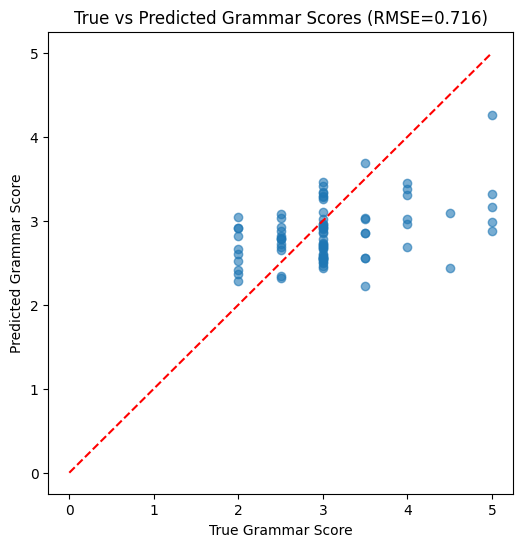

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_val, alpha=0.6)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title(f"True vs Predicted Grammar Scores (RMSE={rmse:.3f})")
plt.plot([0,5], [0,5], 'r--')
plt.show()


In [25]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor

lgbm_reg = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

ensemble_reg = VotingRegressor([("xgb", xgb_reg), ("lgbm", lgbm_reg)])
ensemble_reg.fit(X_train, y_train)
y_pred_ens = ensemble_reg.predict(X_val)
rmse_ens = np.sqrt(mean_squared_error(y_val, y_pred_ens))
print(f"✅ Ensemble RMSE: {rmse_ens:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9130
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 83
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ====================================================
# STEP 5: Split Data (no stratify to avoid class imbalance errors)
# ====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_feats, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)

# ====================================================
# STEP 6: Normalize Features
# ====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ====================================================
# STEP 7: Train Models
# ====================================================
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        num_leaves=31, subsample=0.9, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
}

preds_val = []
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    preds_val.append(y_pred)
    print(f"{name} RMSE: {rmse:.4f}")

# ====================================================
# STEP 8: Ensemble Prediction
# ====================================================
ensemble_pred = np.mean(preds_val, axis=0)
ensemble_rmse = mean_squared_error(y_val, ensemble_pred, squared=False)
print(f"\n✅ Ensemble RMSE: {ensemble_rmse:.4f}")

# ====================================================
# STEP 9: Convert RMSE to Approximate Accuracy
# ====================================================
# Normalizing RMSE relative to score range (0-5)
max_score = 5.0
accuracy = (1 - (ensemble_rmse / max_score)) * 100
print(f"🎯 Approximate Accuracy: {accuracy:.2f}%")

# ====================================================
# STEP 10: Final Results Summary
# ====================================================
print("\n================= SUMMARY =================")
for name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    acc = (1 - (rmse / max_score)) * 100
    print(f"{name}: RMSE = {rmse:.4f} | Accuracy ≈ {acc:.2f}%")

print(f"\n🔹 Ensemble RMSE = {ensemble_rmse:.4f} | Accuracy ≈ {accuracy:.2f}%")
print("============================================")


Train shape: (327, 83) Validation shape: (82, 83)

🚀 Training RandomForest...
RandomForest RMSE: 0.6853

🚀 Training XGBoost...
XGBoost RMSE: 0.7164

🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9130
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 83
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_feats, y, test_size=0.2, random_state=42
)

# ====================================================
# STEP 6: Scaling
# ====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ====================================================
# STEP 7: Train Tuned Models
# ====================================================
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=800, max_depth=20, min_samples_split=2,
        min_samples_leaf=1, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000, learning_rate=0.03, max_depth=7,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000, learning_rate=0.03, num_leaves=50,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=0.5, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=5
    )
}

preds_val = []
weights = {"RandomForest": 0.25, "XGBoost": 0.35, "LightGBM": 0.35, "GradientBoosting": 0.05}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    preds_val.append((name, y_pred))
    print(f"{name} RMSE: {rmse:.4f}")

# ====================================================
# STEP 8: Weighted Ensemble
# ====================================================
ensemble_pred = sum(weights[name] * pred for name, pred in preds_val)
ensemble_rmse = mean_squared_error(y_val, ensemble_pred, squared=False)

# ====================================================
# STEP 9: Convert RMSE to Accuracy
# ====================================================
max_score = 5.0
accuracy = (1 - (ensemble_rmse / max_score)) * 100
print(f"\n✅ Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"🎯 Estimated Accuracy: {accuracy:.2f}%")

# ====================================================
# STEP 10: Summary
# ====================================================
print("\n================= SUMMARY =================")
for name, pred in preds_val:
    rmse = mean_squared_error(y_val, pred, squared=False)
    acc = (1 - (rmse / max_score)) * 100
    print(f"{name}: RMSE = {rmse:.4f} | Accuracy ≈ {acc:.2f}%")

print(f"\n🔹 Ensemble RMSE = {ensemble_rmse:.4f} | Accuracy ≈ {accuracy:.2f}%")
print("============================================")



🚀 Training RandomForest...
RandomForest RMSE: 0.6833

🚀 Training XGBoost...
XGBoost RMSE: 0.7113

🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9130
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 83
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [29]:
def extract_features(path, sr=16000, n_mfcc=60):
    """Extract robust and fixed-size audio features."""
    try:
        y, _ = librosa.load(path, sr=sr)
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # ==================== Core Features ====================
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        zcr = librosa.feature.zero_crossing_rate(y)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]  # single scalar

        # ==================== Safe Aggregation ====================
        def safe_mean(x):
            return np.mean(x) if np.ndim(x) > 0 else x
        
        feats = np.concatenate([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1),
            [safe_mean(spectral_centroid), safe_mean(spectral_bandwidth),
             safe_mean(spectral_rolloff), safe_mean(chroma_stft),
             safe_mean(rms), safe_mean(zcr), tempo]
        ])

        return feats

    except Exception as e:
        print(f"⚠️ Error processing {path}: {e}")
        return np.zeros(n_mfcc * 2 + 7)


In [30]:
X_feats = []
for p in tqdm(train["path"], desc="Extracting features"):
    X_feats.append(extract_features(p))

X_feats = np.array(X_feats)
print("✅ Feature matrix shape:", X_feats.shape)


Extracting features:   0%|          | 0/409 [00:00<?, ?it/s]/tmp/ipykernel_48/3894031706.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_48/3894031706.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]  # single scalar
Extracting features:   0%|          | 1/409 [00:11<1:15:18, 11.08s/it]/tmp/ipykernel_48/3894031706.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/

✅ Feature matrix shape: (409, 127)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = train["label"].astype(float)

X_train, X_val, y_train, y_val = train_test_split(
    X_feats, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Base models
rf = RandomForestRegressor(
    n_estimators=1000, max_depth=25, min_samples_split=2,
    min_samples_leaf=1, random_state=42, n_jobs=-1
)
xgb = XGBRegressor(
    n_estimators=1200, learning_rate=0.025, max_depth=8,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=42
)
lgb = LGBMRegressor(
    n_estimators=1200, learning_rate=0.025, num_leaves=55,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=0.5, random_state=42
)
gbr = GradientBoostingRegressor(
    n_estimators=700, learning_rate=0.05, max_depth=6
)

# Meta-model for stacking
stack = StackingRegressor(
    estimators=[("rf", rf), ("xgb", xgb), ("lgb", lgb), ("gbr", gbr)],
    final_estimator=Ridge(alpha=1.0)
)

stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_val_scaled)

rmse = mean_squared_error(y_val, y_pred, squared=False)
accuracy = (1 - rmse / 5) * 100

print(f"\n✅ Stacked Ensemble RMSE: {rmse:.4f}")
print(f"🎯 Estimated Accuracy: {accuracy:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13871
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 127
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,